<a href="https://colab.research.google.com/github/androbaza/smlm-seg/blob/main/SMLM_image_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
%cd /content/drive/MyDrive/ANNA-PALM
%tensorflow_version 1.x
!pip install scipy==1.2 wand magickwand
# !pip install -r requirements.txt
!apt-get install libmagickwand-dev

In [4]:
import numpy as np
import cv2, skimage, os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow 
from skimage import morphology
from skimage.measure import label
from wand.image import Image
from skimage.exposure import rescale_intensity
from skimage.segmentation import random_walker

In [5]:
# functions required for dataset creation

def make_tiles(input, output_dir, img_n):
    i = 0
    with Image(filename=input) as img:
        for h in range(0, img.height, 512):
            for w in range(0, img.width, 512):
                w_end = w + 512
                if w_end > img.width:
                    w_end = img.width
                    w = img.width - 512
                h_end = h + 512
                if h_end > img.height:
                    h_end = img.height
                    h = img.height - 512
                with img[w:w_end, h:h_end] as chunk:
                    chunk.save(filename=output_dir+'A_'+str(img_n)+'_tile_{0}.png'.format(i))
                i += 1

def read(path):
    """Reads an image from the specified path.

    Args:
        path (str): image path.

    :Returns:
        img (numpy.array): RGB image
    """
    return imread(path, as_gray=1)

def rotate_pair(img, mask, degree):
    """Rotates image and mask for the degree from range [-degree, degree]
    Args:
        img (numpy.array): RGB or grayscale image.
        mask (numpy.array): image mask.
        degree (int): maximum rotation degree.
    Returns:
        img (numpy.array): rotated image.
        mask (numpy.array): rotated image mask.
    """
    rotation_degree = int(random.random() * degree)
    rotation_degree = rotation_degree if random.random() < 0.5 else -rotation_degree

    img = rotate(img, rotation_degree)
    mask = rotate(mask, rotation_degree)

    return img, mask

def rotate(img, degree):
    """Rotates image for the specified degree.
    Args:
        img (numpy.array): RGB or grayscale image.
        degree (int): rotation degree
    Returns:
        img (numpy.array): rotated image.
    """
    pil_img = np2pil(img)
    pil_img = pil_img.rotate(degree)
    np_img = pil2np(pil_img)

    return np_img

def flip_pair(img, mask):
    """Flips image and mask horizontally with probability p.
    Args:
        img (numpy.array): RGB or grayscale image.
        mask (numpy.array): object image.
        p (float): probability of flipping.
    Returns:
        img (numpy.array): flipped image.
        mask (numpy.array): flipped object image.
    """
    # if random.random() < p:
    img = flip(img)
    mask = flip(mask)

    return img, mask

def flip(img):
    """Flips image horizontally.
    Args:
        img (numpy.array): RGB or grayscale image.
        p (float): probability of flipping.
    Returns:
        img (numpy.array): flipped image.
    """
    # return img[:, ::-1]
    
    # if random.random() < p:
    if len(img.shape) == 3:
        return img[:, ::-1, :]
    else:
        return img[:, ::-1]
    # else:
    #     return img

def embed_pair(img_top, mask_top, img_bottom, mask_bottom):

    m_top = (mask_top[:, :, 0] > 0) | (mask_top[:, :, 1] > 0) | (mask_top[:, :, 2] > 0)

    # res = skimage.util.img_as_uint(img_bottom.copy())
    mask_comb = mask_bottom.copy()

    # copy the pixels from under the mask of the top image to bottom image
    # res[m_top] = skimage.util.img_as_uint(img_top[m_top])
    mask_comb[m_top] = mask_top[m_top]

    top_non_zero = img_top[:, :] > 0
    cc = skimage.util.img_as_uint(img_bottom.copy())

    # copy the non-zero pixels from the top image to bottom image
    cc[top_non_zero] = skimage.util.img_as_uint(img_top[top_non_zero])

    return mask_comb, cc

def plot_comparison(original, filtered):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8), sharex=True,
                                  sharey=True)
  ax1.imshow(original, cmap=plt.cm.gray)
  ax1.axis('off')
  ax2.imshow(filtered, cmap=plt.cm.gray)
  # ax2.set_title(filter_name)
  ax2.axis('off')

# Microtubules + anna-palm

In [ ]:
# images have to be grey, 1-layer for anna-palm input
%%capture

input_dir = '/content/drive/MyDrive/ANNA-PALM/Microtubules/raw_inputs'
output_dir = '/content/drive/MyDrive/ANNA-PALM/Microtubules/test/tiled/'

img_n = 0

# auto-clean the output folders at beginning of every execution
for fname in os.listdir(output_dir):
  os.remove(os.path.join(output_dir, fname))

for fname in os.listdir(input_dir):
    temp_file = os.path.join(output_dir, os.path.splitext(fname)[0])+"temp.png"
    skimage.io.imsave(temp_file, 
                    skimage.io.imread(os.path.join(input_dir, fname), as_gray=1), check_contrast=False)
    make_tiles(temp_file, output_dir, img_n)
    os.remove(temp_file)
    img_n += 1

for fname in os.listdir(output_dir):
    img = skimage.io.imread(os.path.join(output_dir, fname), as_gray=1)
    if(np.count_nonzero(img)/img.size < 0.01): 
      os.remove(os.path.join(output_dir, fname))

In [17]:
print(len(os.listdir('/content/drive/MyDrive/ANNA-PALM/Microtubules/test/tiled/')))

209


In [ ]:
# main ANNA-PALM model execution. 
# %%capture

# smlm_datasets.py line 176 ---> change the value to len+1

for fname in os.listdir('/content/drive/MyDrive/ANNA-PALM/Microtubules/outputs'):
  os.remove(os.path.join('/content/drive/MyDrive/ANNA-PALM/Microtubules/outputs', fname))

%cd /content/drive/MyDrive/ANNA-PALM
!python run_img.py --workdir=/content/drive/MyDrive/ANNA-PALM/Microtubules --load_dir=/content/drive/MyDrive/ANNA-PALM/Microtubules/945 --phase=test

In [20]:
# delete unneeded temp files, convert the images to binary masks
%%capture
input_dir = '/content/drive/MyDrive/ANNA-PALM/Microtubules/outputs'
output_dir = '/content/drive/MyDrive/ANNA-PALM/Microtubules/masked'

for fname in os.listdir(input_dir):
    if fname.endswith("reco_B_b0_i0.tif"):
        img = skimage.io.imread(os.path.join(input_dir, fname), as_gray=1)
        blur = (cv2.GaussianBlur(img,(3,3),0)*255).astype(np.uint8)
        ret, fig = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # filtered1 = morphology.erosion(morphology.dilation(labels2, morphology.square(4)), morphology.square(2))

        filtered = morphology.remove_small_objects(fig > 0, 100)

        if(np.count_nonzero(filtered)/filtered.size < 0.001): 
            continue
        skimage.io.imsave(os.path.join(output_dir, os.path.splitext(os.path.splitext(fname)[0])[0])+"_masked.png", filtered)
    else:
        os.remove(os.path.join(input_dir, fname))

# Vesicles

In [ ]:
# %%capture

input_dir = '/content/drive/MyDrive/ANNA-PALM/Vesicles/raw_inputs'
output_dir = '/content/drive/MyDrive/ANNA-PALM/Vesicles/tiled/'

img_n = 0

# auto-clean the output folders at beginning of every execution
for fname in os.listdir(output_dir):
  os.remove(os.path.join(output_dir,fname))

for fname in os.listdir(input_dir):
    temp_file = os.path.join(output_dir, os.path.splitext(fname)[0])+"temp.png"
    skimage.io.imsave(temp_file, 
                    skimage.io.imread(os.path.join(input_dir, fname), as_gray=1), check_contrast=False)
    make_tiles(temp_file, output_dir, img_n)
    os.remove(temp_file)
    img_n += 1

In [16]:
# delete unneeded temp files, convert the images to binary masks
%%capture
input_dir = '/content/drive/MyDrive/ANNA-PALM/Vesicles/tiled'
output_dir = '/content/drive/MyDrive/ANNA-PALM/Vesicles/masked'

# auto-clean the output folders at beginning of every execution
for fname in os.listdir(output_dir):
  os.remove(os.path.join(output_dir,fname))

for fname in os.listdir(input_dir):
    
    img = skimage.io.imread(os.path.join(input_dir, fname), as_gray=1)

    markers = np.zeros(img.shape, dtype=np.uint)
    markers[img < 0.01] = 1
    markers[img > 0.1] = 2

    # Run random walker algorithm
    labels = random_walker(img, markers, beta=5, mode='bf')
    labels2 = rescale_intensity(labels, out_range=(0, 1))

    # filtered1 = morphology.erosion(morphology.dilation(labels2, morphology.disk(3)), morphology.disk(2))

    filtered = morphology.remove_small_holes(
        morphology.remove_small_objects(
            labels2 > 0, 100),
        200)

    if(np.count_nonzero(filtered)/filtered.size < 0.001):
        os.remove(os.path.join(input_dir,fname)) 
        continue
    skimage.io.imsave(os.path.join(output_dir, os.path.splitext(os.path.splitext(fname)[0])[0])+"_masked.png", filtered)

# Mask combinations

read images to lists, take ith element from both, (rotate, (embed)x2)x4, flip, (rotate, (embed)x2)x4: 28 combinations per 1 image

In [6]:
%%capture
%cd /content/drive/MyDrive/ANNA-PALM/segmentation_image_augmentation
!pip install -r requirements.txt

import shutil
from utils import *
import skimage, random, math
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage.io import imread

In [19]:
# copy files to respective folders, correct names

ves_im = '/content/drive/MyDrive/ANNA-PALM/Vesicles/tiled'
ves_mask = '/content/drive/MyDrive/ANNA-PALM/Vesicles/masked'

mt_im = '/content/drive/MyDrive/ANNA-PALM/Microtubules/test/tiled/'
mt_mask = '/content/drive/MyDrive/ANNA-PALM/Microtubules/masked'

ves_im_mask = '/content/drive/MyDrive/ANNA-PALM/Vesicles/tile_mask'
mt_im_mask = '/content/drive/MyDrive/ANNA-PALM/Microtubules/tile_mask'

# auto-clean the output folders at beginning of every execution
for fname in os.listdir(ves_im_mask):
  os.remove(os.path.join(ves_im_mask, fname))

for fname in os.listdir(mt_im_mask):
  os.remove(os.path.join(mt_im_mask, fname))
#-------------------------------------------------------------#

for file in os.listdir(ves_im):
    file_path = os.path.join(ves_im, file)
    shutil.copy(file_path, os.path.join(ves_im_mask, 'data_' + file))

for file in os.listdir(ves_mask):
    file_path = os.path.join(ves_mask, file)
    shutil.copy(file_path, os.path.join(ves_im_mask, 'masked_' + file))

for file in os.listdir(mt_im):
    file_path = os.path.join(mt_im, file)
    shutil.copy(file_path, os.path.join(mt_im_mask, 'data_' + file))

for file in os.listdir(mt_mask):
    file_path = os.path.join(mt_mask, file)
    shutil.copy(file_path, os.path.join(mt_im_mask, 'masked_' + file))

In [8]:
images_path, masks_path = get_img_mask_list('/content/drive/MyDrive/ANNA-PALM/Microtubules/tile_mask')
images_path2, masks_path2 = get_img_mask_list('/content/drive/MyDrive/ANNA-PALM/Vesicles/tile_mask')

images_mt = [read(f) for f in images_path]
images_ves = [read(f) for f in images_path2]

masks_ves = [color_mask((skimage.color.gray2rgb(mask)), [0, 255, 255]) 
                          for mask in (read(f) for f in masks_path2)]
masks_mt = [color_mask((skimage.color.gray2rgb(mask)), [128, 255, 0]) 
                          for mask in (read(f) for f in masks_path)]

In [ ]:
save_dir = '/content/drive/MyDrive/ANNA-PALM/combined-images/'

# auto-clean the output folders at beginning of every execution
for fname in os.listdir(save_dir):
  os.remove(os.path.join(save_dir, fname))

k = 0
for i, im in enumerate(images_mt):
  
  for j, mask in enumerate(images_ves):
    
    top = 'mt_top'

    # save original overlap
    comb_mask, comb_im = embed_pair(images_mt[i], masks_mt[i], images_ves[j], masks_ves[j])
    skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_comb_im.png", comb_im)
    skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_mask.png", comb_mask)

    # save rotations
    rot = 0
    for x in range(3):
      rot += 90
      comb_mask, comb_im = embed_pair(rotate(images_mt[i], rot), rotate(masks_mt[i], rot), rotate(images_ves[j], rot), rotate(masks_ves[j], rot))
      skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_rot{}_comb_im.png".format(rot), comb_im)
      skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_rot{}_mask.png".format(rot), comb_mask)

    # save flipped rotations
    rot = 0
    for x in range(3):
      rot += 90
      comb_mask, comb_im = embed_pair(flip(rotate(images_mt[i], rot)), flip(rotate(masks_mt[i], rot)), flip(rotate(images_ves[j], rot)), flip(rotate(masks_ves[j], rot)))
      skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_rot{}_flip_comb_im.png".format(rot), comb_im)
      skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_rot{}_flip_mask.png".format(rot), comb_mask)

    # now change overlap order

    top = 'ves_top'

    # save original overlap
    comb_mask, comb_im = embed_pair(images_ves[j], masks_ves[j], images_mt[i], masks_mt[i])
    skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_comb_im.png", comb_im)
    skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_mask.png", comb_mask)

    # save rotations
    rot = 0
    for x in range(3):
      rot += 90
      comb_mask, comb_im = embed_pair( rotate(images_ves[j], rot), rotate(masks_ves[j], rot), rotate(images_mt[i], rot), rotate(masks_mt[i], rot))
      skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_rot{}_comb_im.png".format(rot), comb_im)
      skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_rot{}_mask.png".format(rot), comb_mask)

    # save flipped rotations
    rot = 0
    for x in range(3):
      rot += 90
      comb_mask, comb_im = embed_pair( flip(rotate(images_ves[j], rot)), flip(rotate(masks_ves[j], rot)), flip(rotate(images_mt[i], rot)), flip(rotate(masks_mt[i], rot)))
      skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_rot{}_flip_comb_im.png".format(rot), comb_im)
      skimage.io.imsave(str(save_dir)+"{}_".format(k)+top+"_rot{}_flip_mask.png".format(rot), comb_mask)

    k += 1

In [ ]:
len(os.listdir(save_dir))

# morphological

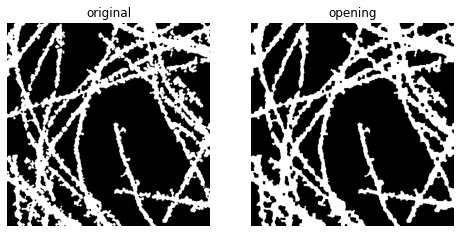

In [ ]:
import cv2

# Load image, convert to grayscale, Gaussian blur, Otsu's threshold
# image = cv2.imread('1.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray, (3,3), 0)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

thresh = binarize(multi_eroded)

# Filter using contour area and remove small noise
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 350:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Morph close and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

plot_comparison(thresh, close, 'opening')

# cv2_imshow('thresh', thresh)
# cv2_imshow('close', close)
# cv2.waitKey()

In [ ]:
cv2.imwrite("tub-5x5-closing-rem-small.png", close)

True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  """Entry point for launching an IPython kernel.


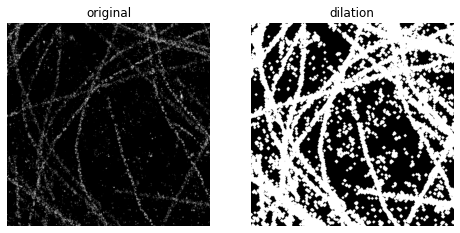

In [ ]:
rem_small = morphology.remove_small_holes(multi_eroded,1)
plot_comparison(orig_phantom, rem_small, 'dilation')

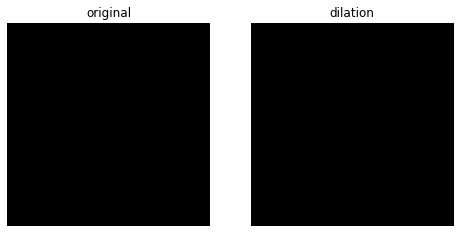

In [ ]:
bin = create_mask(closed)
rem_small = morphology.remove_small_objects(bin ,2)
plot_comparison(bin, rem_small, 'dilation')

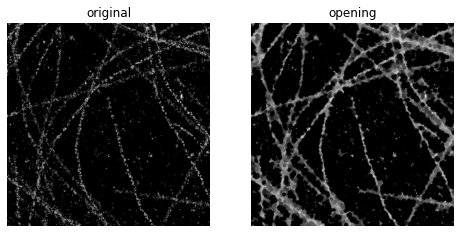

In [ ]:
closed = closing(orig_phantom, disk(4))
plot_comparison(orig_phantom, closed, 'opening')

In [ ]:
%cd /content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp

/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp


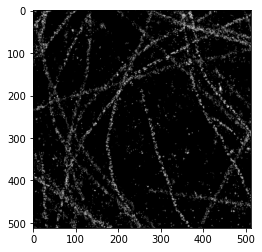

In [ ]:
import skimage
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage.io import imread

im = skimage.io.imread("/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/test_workdir_exp1/test/12.png", as_gray=1)
orig_phantom = img_as_ubyte(im)
fig, ax = plt.subplots()
ax.imshow(orig_phantom, cmap=plt.cm.gray)

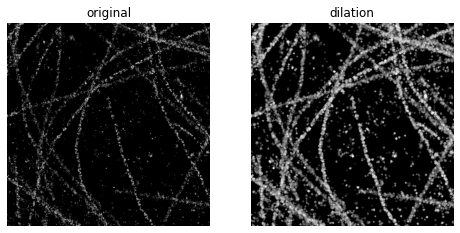

In [ ]:
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk, square  # noqa

# footprint = disk(3)
# m = square(5)
dilated = dilation(orig_phantom, disk(2))
plot_comparison(orig_phantom, dilated, 'dilation')

## Random walker segmentation

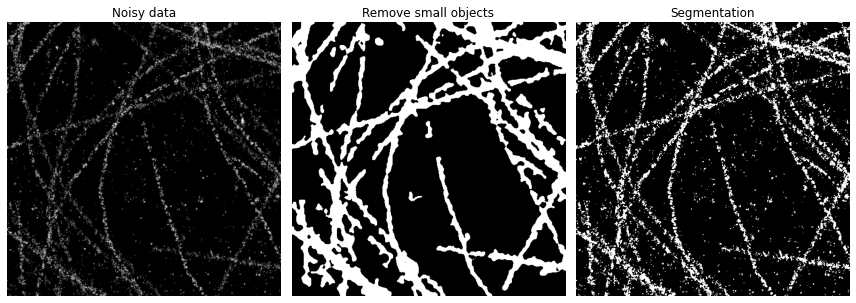

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

rng = np.random.default_rng()

img = skimage.io.imread("/content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp/1-m.png", as_gray=1)

markers = np.zeros(data.shape, dtype=np.uint)
markers[data < 0.1] = 1
markers[data > 0.2] = 2

# Run random walker algorithm
labels = random_walker(data, markers, beta=10, mode='bf')
labels2 = rescale_intensity(labels, out_range=(0, 1))

filtered1 = morphology.erosion(morphology.dilation(labels2, morphology.square(4)), morphology.square(2))

filtered = morphology.remove_small_holes(
    morphology.remove_small_objects(
        filtered1 > 0, 150),
    50)

filtered = skimage.filters.median(filtered, morphology.disk(4))

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray')
ax1.axis('off')
ax1.set_title('Noisy data')
# ax2.imshow(markers, cmap='magma')
# ax2.axis('off')
# ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray')
ax3.axis('off')
ax3.set_title('Segmentation')
ax2.imshow(filtered, cmap='gray')
ax2.axis('off')
ax2.set_title('Remove small objects')

fig.tight_layout()
plt.show()

In [ ]:
import cv2
out = 1*filtered#.astype(int)
%cd /content/drive/MyDrive/MMsegmentation-data/ANNA-PALM/mask-comp/
skimage.io.imsave("1-m-mask2.png", filtered.astype(int))
# cv2.imwrite("1-m-mask2.png", out)
# plt.imshow(out)